In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import talib  # TA-Lib

plt.rcParams["figure.figsize"] = (12, 5)
pd.set_option("display.max_columns", None)



In [6]:
DATA_DIR = Path("../data")  # adjust to your folder

TICKERS = ["AAPL", "AMZN", "GOOG", "META", "MSFT", "NVDA"] 



In [9]:
def load_price_data(ticker: str) -> pd.DataFrame:
    """
    Load OHLCV price data for a ticker from CSV.
    Expects file like DATA_DIR / f'{ticker}.csv'.
    """
    file_path = DATA_DIR / f"{ticker}.csv"
    df = pd.read_csv(file_path)

    # Try to find date column
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.set_index("Date").sort_index()
    elif "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"])
        df = df.set_index("date").sort_index()
    else:
        raise ValueError(f"No Date column found in {file_path}")

    # Normalize column names
    df.columns = [c.strip().title().replace("_", " ") for c in df.columns]

    # Required columns WITHOUT Adj Close
    required_cols = ["Open", "High", "Low", "Close", "Volume"]
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns {missing} in {file_path}")

    return df[required_cols].copy()


In [11]:
def add_ta_indicators(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add TA-Lib indicators to an OHLCV DataFrame.
    Expects columns: Open, High, Low, Close, Volume.
    """
    df = df.copy()
    close = df["Close"]

    # Moving Averages
    df["SMA_20"] = talib.SMA(close, timeperiod=20)
    df["SMA_50"] = talib.SMA(close, timeperiod=50)

    # RSI
    df["RSI_14"] = talib.RSI(close, timeperiod=14)

    # MACD
    macd, macd_signal, macd_hist = talib.MACD(
        close,
        fastperiod=12,
        slowperiod=26,
        signalperiod=9
    )
    df["MACD"] = macd
    df["MACD_signal"] = macd_signal
    df["MACD_hist"] = macd_hist

    # Daily log returns (based on Close instead of Adj Close)
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))

    return df


In [13]:
test_df = load_price_data("AAPL")
test_df.head()


,Open,High,Low,Close,Volume
Date,,,,,
2009-01-02,2.575630,2.730385,2.554037,2.721686,746015200
2009-01-05,2.794266,2.884539,2.780469,2.836553,1181608400
2009-01-06,2.877641,2.914229,2.770872,2.789767,1289310400
2009-01-07,2.753477,2.774170,2.706990,2.729484,753048800
2009-01-08,2.712090,2.793666,2.700393,2.780169,673500800


In [14]:
ind_df = add_ta_indicators(test_df)
ind_df.tail()


,Open,High,Low,Close,Volume,SMA_20,SMA_50,RSI_14,MACD,MACD_signal,MACD_hist,log_return
Date,,,,,,,,,,,,
2023-12-22,193.353962,193.581821,191.164647,191.788757,37149600,191.856618,183.572859,54.672784,2.633141,3.235256,-0.602115,-0.005563
2023-12-26,191.798670,192.076049,191.025969,191.243912,28919300,192.018094,183.858864,53.090049,2.304751,3.049155,-0.744404,-0.002845
2023-12-27,190.689158,191.689703,189.302247,191.342972,48087700,192.154308,184.149424,53.354446,2.029104,2.845145,-0.816041,0.000518
2023-12-28,192.323710,192.838849,191.362784,191.768951,34049900,192.362839,184.479567,54.540999,1.823998,2.640915,-0.816918,0.002224
2023-12-29,192.085953,192.581275,189.936256,190.728775,42672100,192.490633,184.814828,51.121347,1.559539,2.424640,-0.865101,-0.005439


In [15]:
def plot_ticker_indicators(df: pd.DataFrame, ticker: str):
    """
    Plot price + SMAs, RSI, and MACD for a given ticker DataFrame.
    """
    # 1. Price + SMAs
    plt.figure(figsize=(14, 5))
    plt.plot(df.index, df["Close"], label="Close")
    plt.plot(df.index, df["SMA_20"], label="SMA 20")
    plt.plot(df.index, df["SMA_50"], label="SMA 50")
    plt.title(f"{ticker}: Close Price with SMAs")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 2. RSI
    plt.figure(figsize=(14, 3))
    plt.plot(df.index, df["RSI_14"], label="RSI 14")
    plt.axhline(70, linestyle="--", label="Overbought")
    plt.axhline(30, linestyle="--", label="Oversold")
    plt.title(f"{ticker}: RSI (14)")
    plt.xlabel("Date")
    plt.ylabel("RSI")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 3. MACD
    plt.figure(figsize=(14, 4))
    plt.plot(df.index, df["MACD"], label="MACD")
    plt.plot(df.index, df["MACD_signal"], label="Signal")
    plt.bar(df.index, df["MACD_hist"], alpha=0.5, label="Histogram")
    plt.title(f"{ticker}: MACD")
    plt.xlabel("Date")
    plt.ylabel("MACD")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


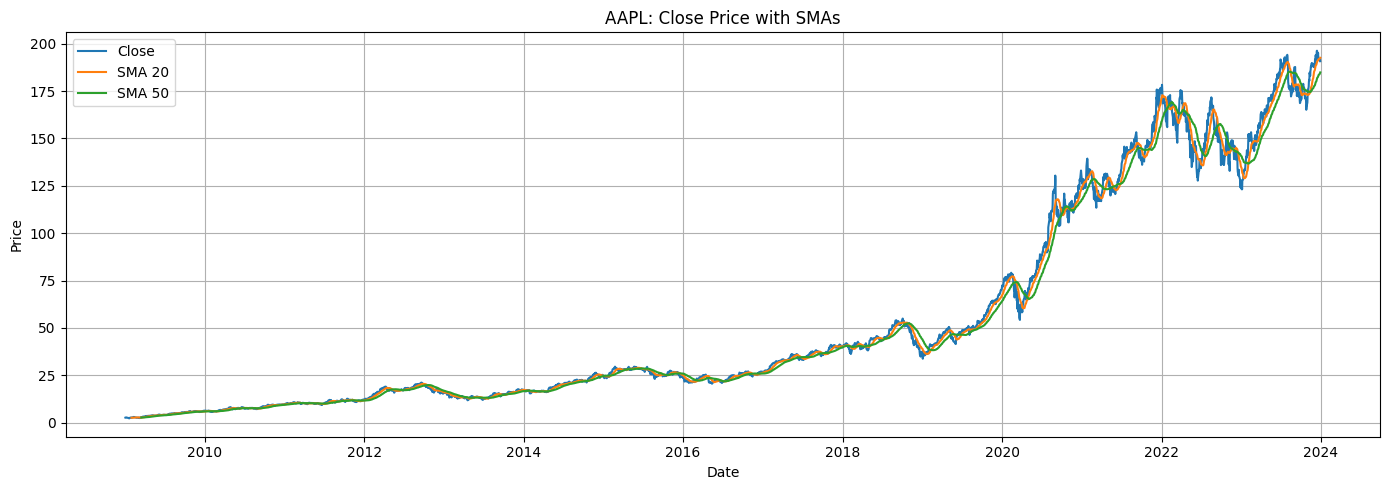

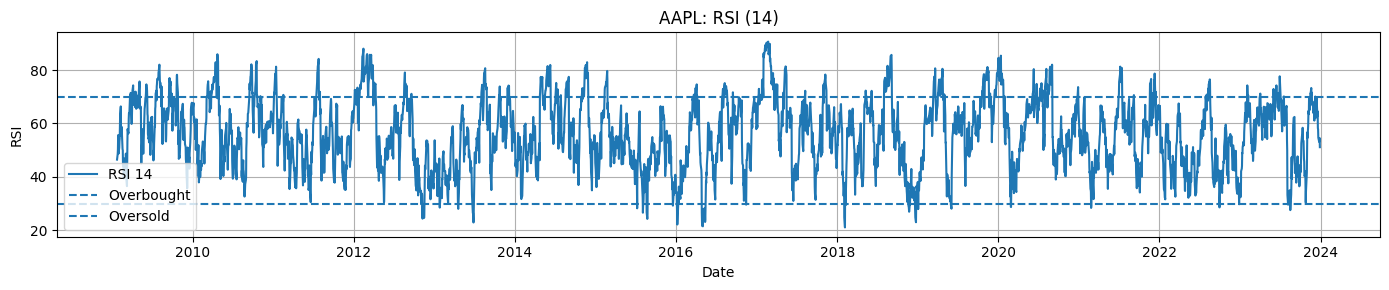

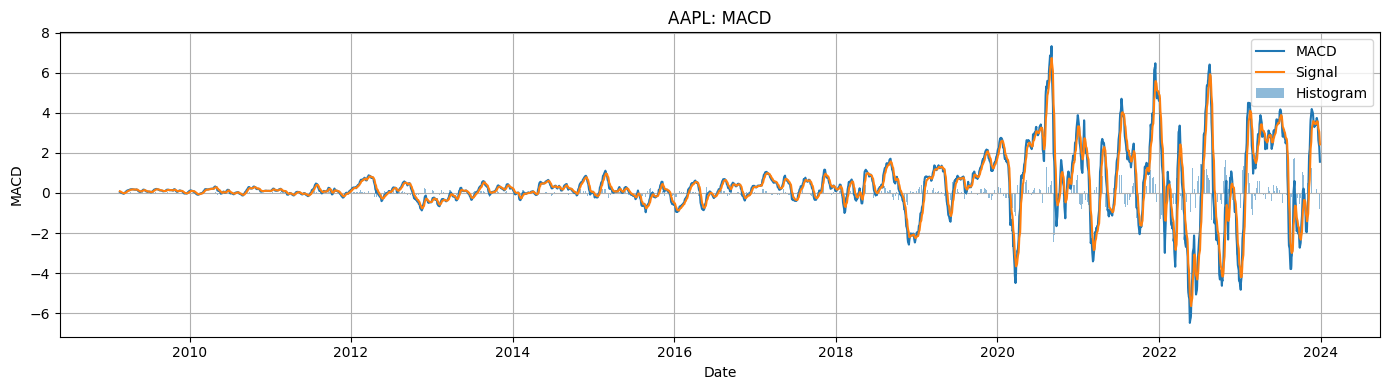

In [16]:
test_df = load_price_data("AAPL")
ind_df = add_ta_indicators(test_df)

# Now plot
plot_ticker_indicators(ind_df, "AAPL")



=== Processing AAPL ===
Mean daily return: 0.00113
Annualized return: 28.37%
Annualized volatility: 28.24%


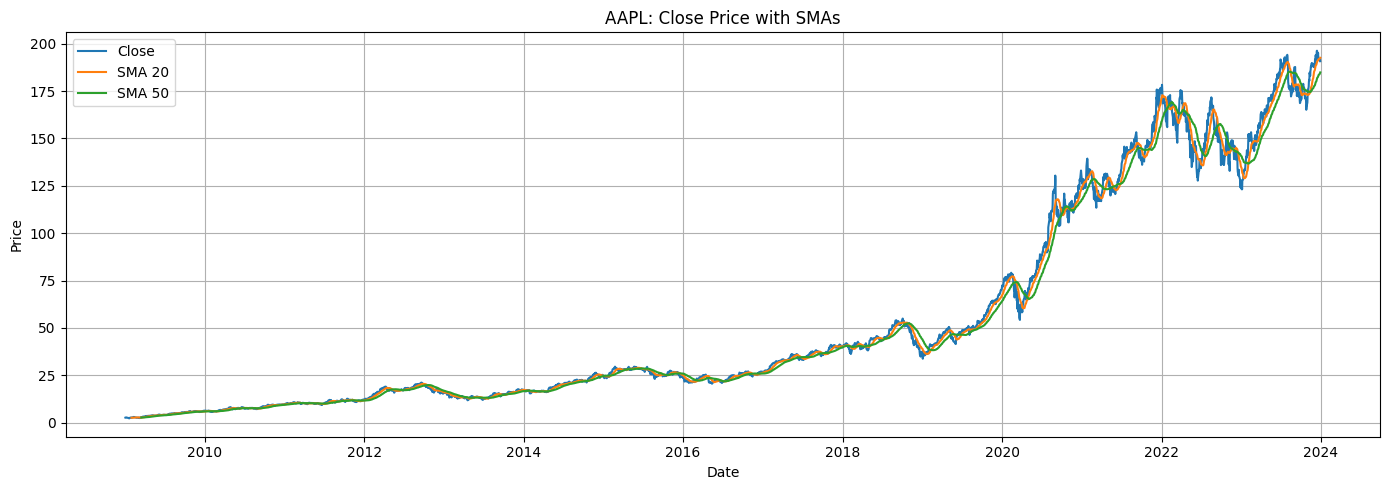

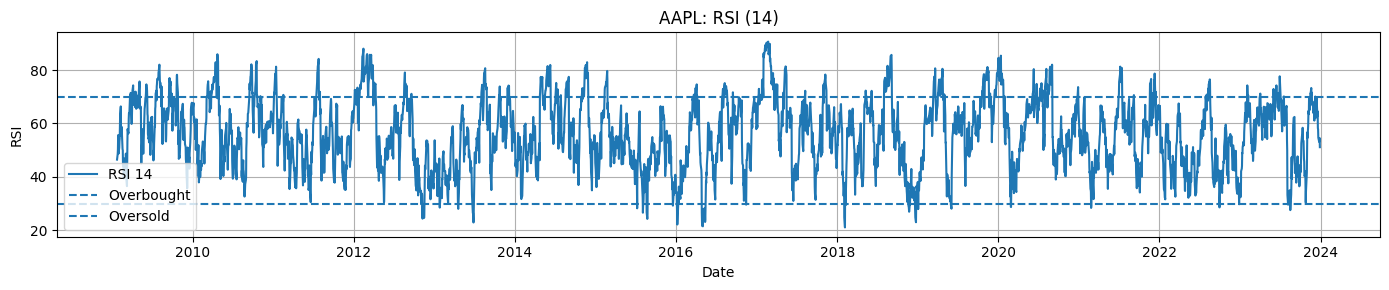

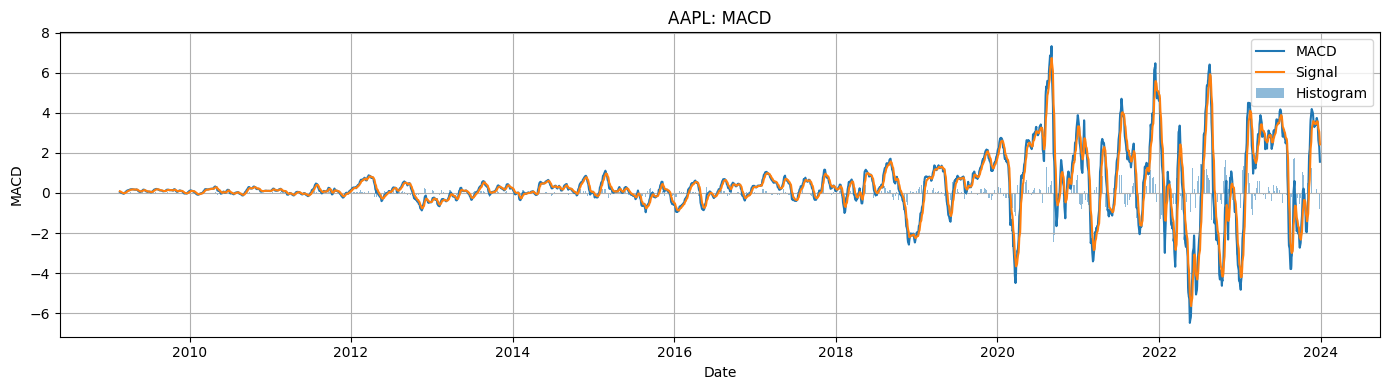


=== Processing AMZN ===
Mean daily return: 0.00102
Annualized return: 25.64%
Annualized volatility: 33.72%


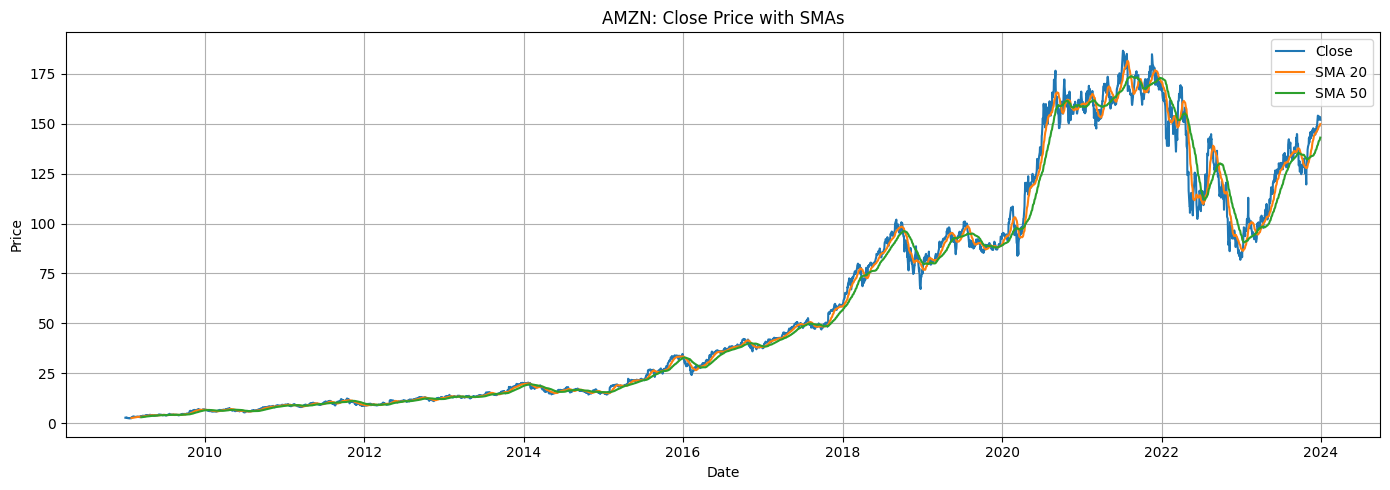

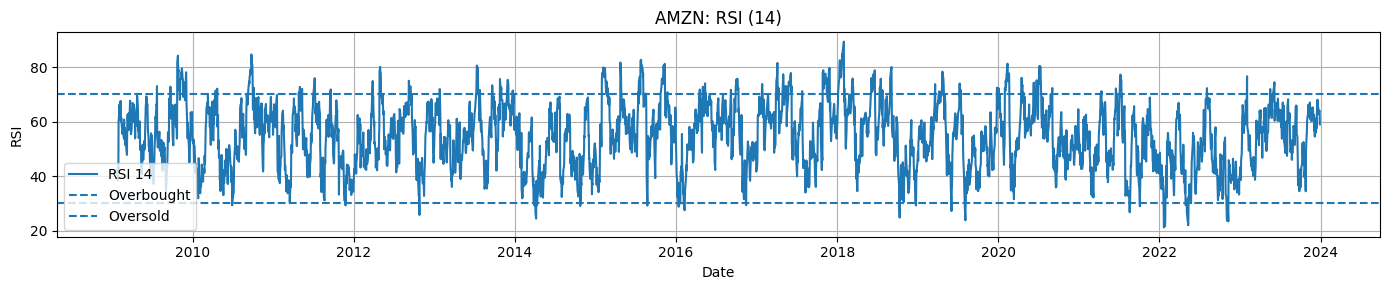

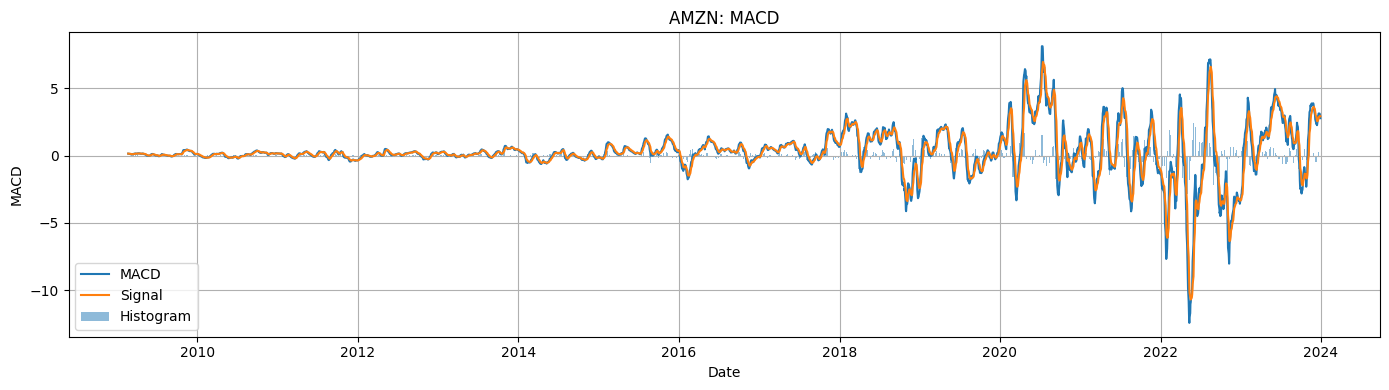


=== Processing GOOG ===
Mean daily return: 0.00077
Annualized return: 19.34%
Annualized volatility: 27.03%


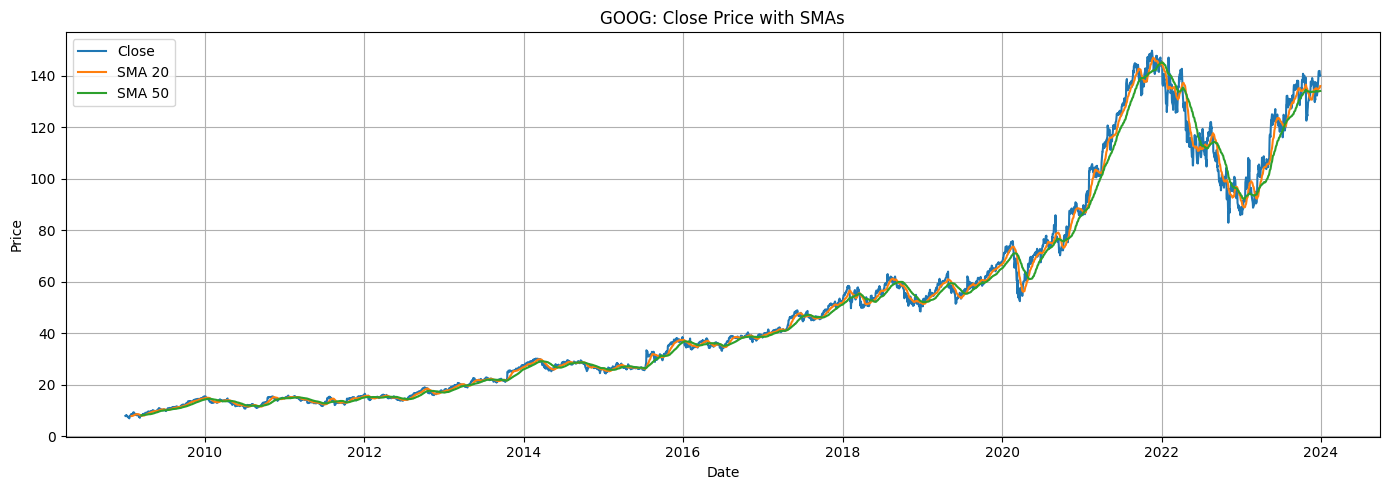

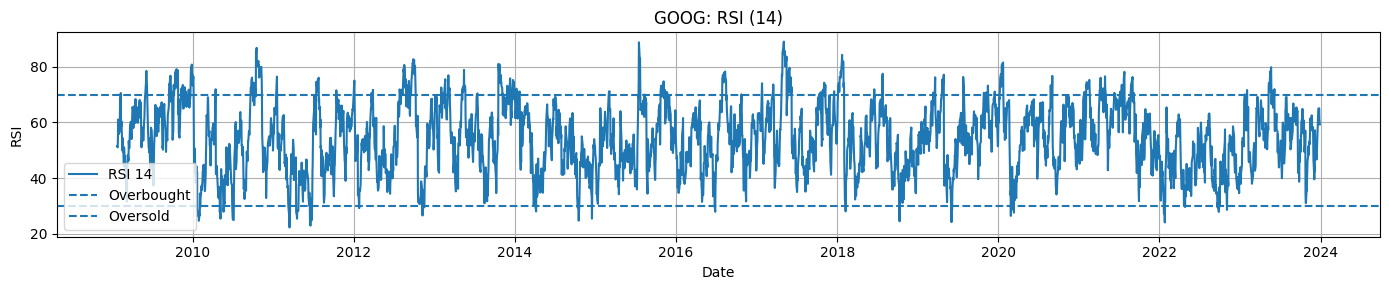

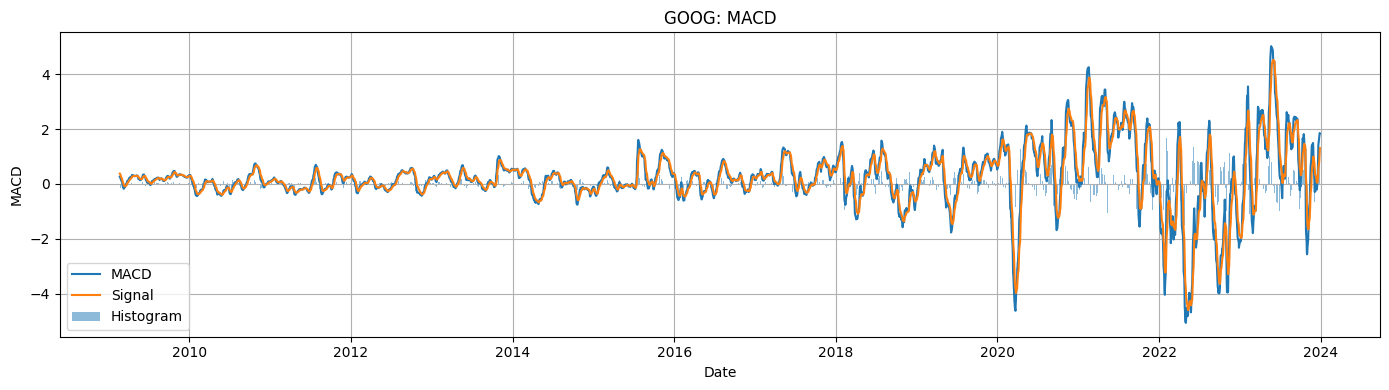


=== Processing META ===
Mean daily return: 0.00094
Annualized return: 23.70%
Annualized volatility: 39.51%


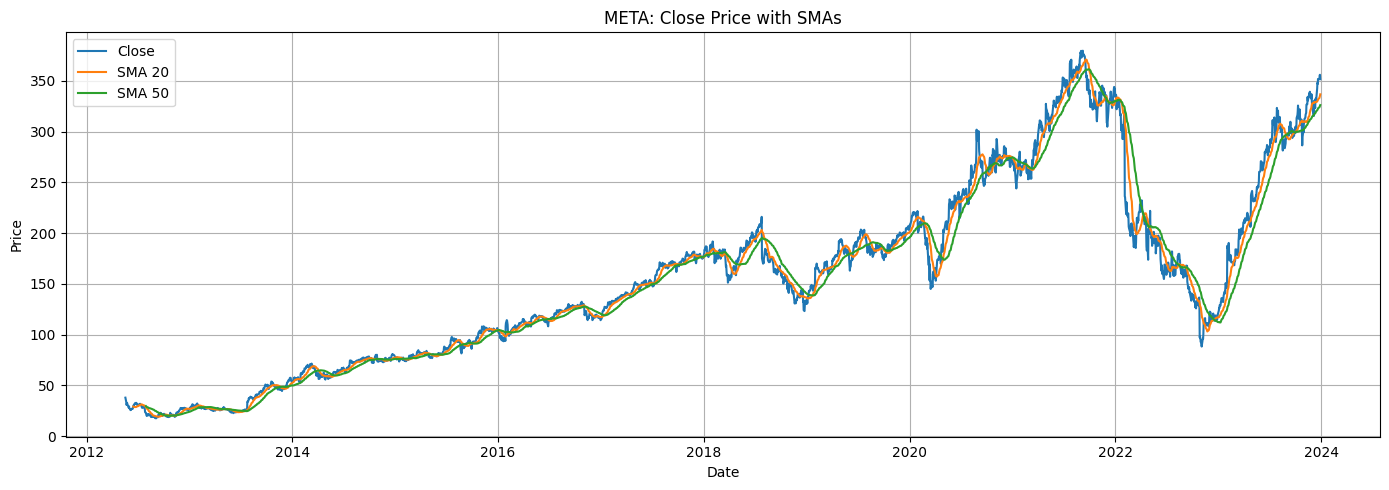

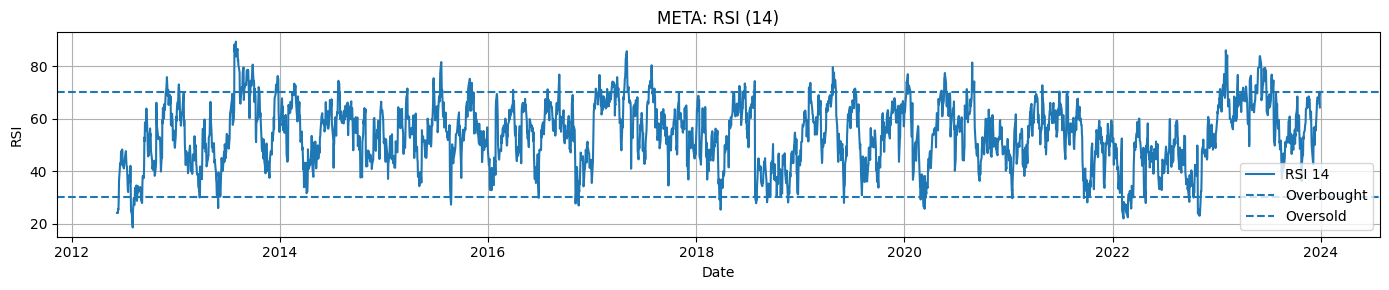

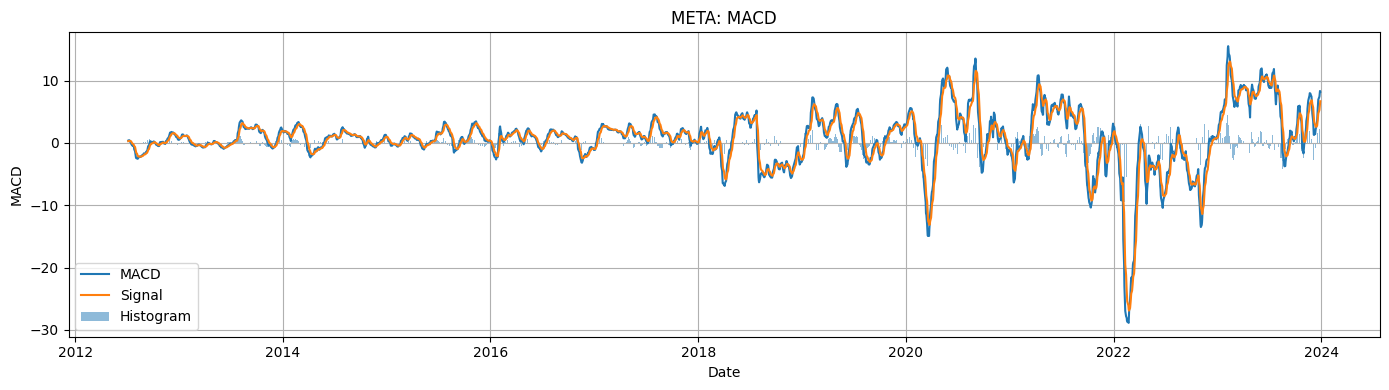


=== Processing MSFT ===
Mean daily return: 0.00092
Annualized return: 23.07%
Annualized volatility: 26.24%


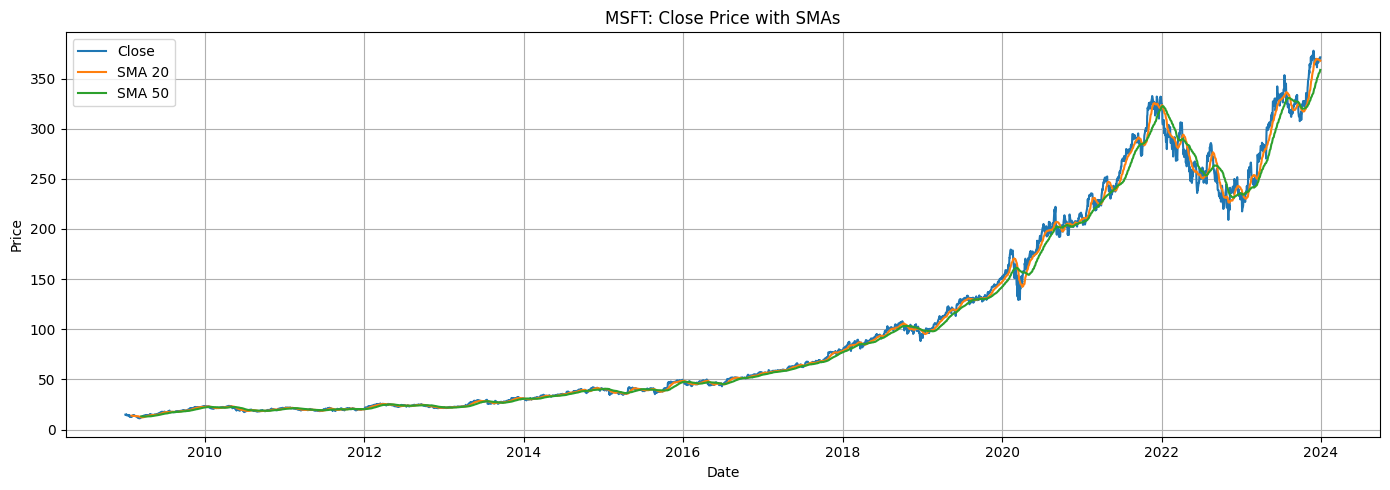

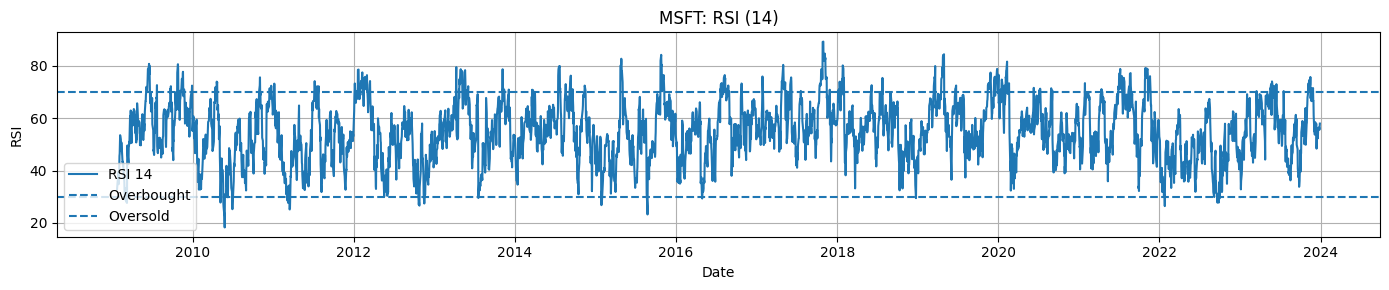

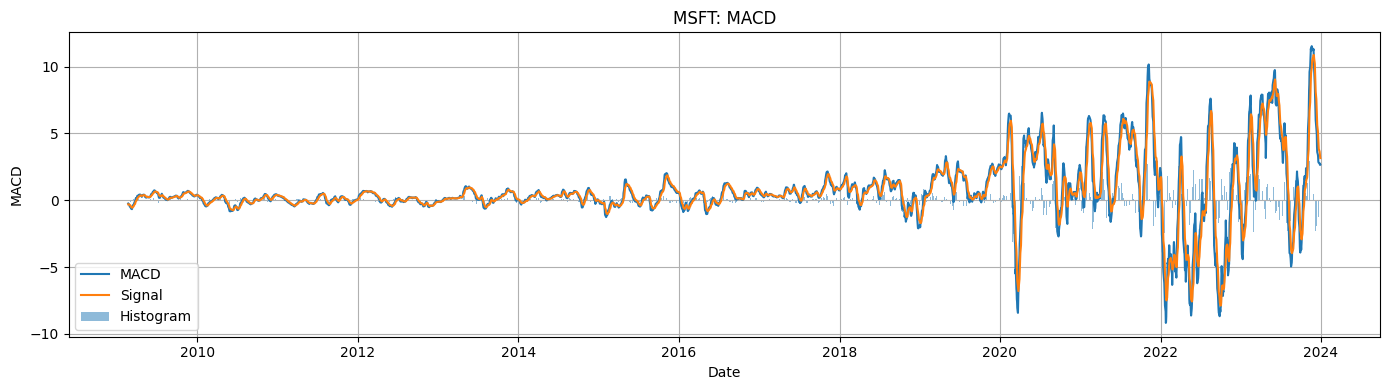


=== Processing NVDA ===
Mean daily return: 0.00145
Annualized return: 36.50%
Annualized volatility: 45.01%


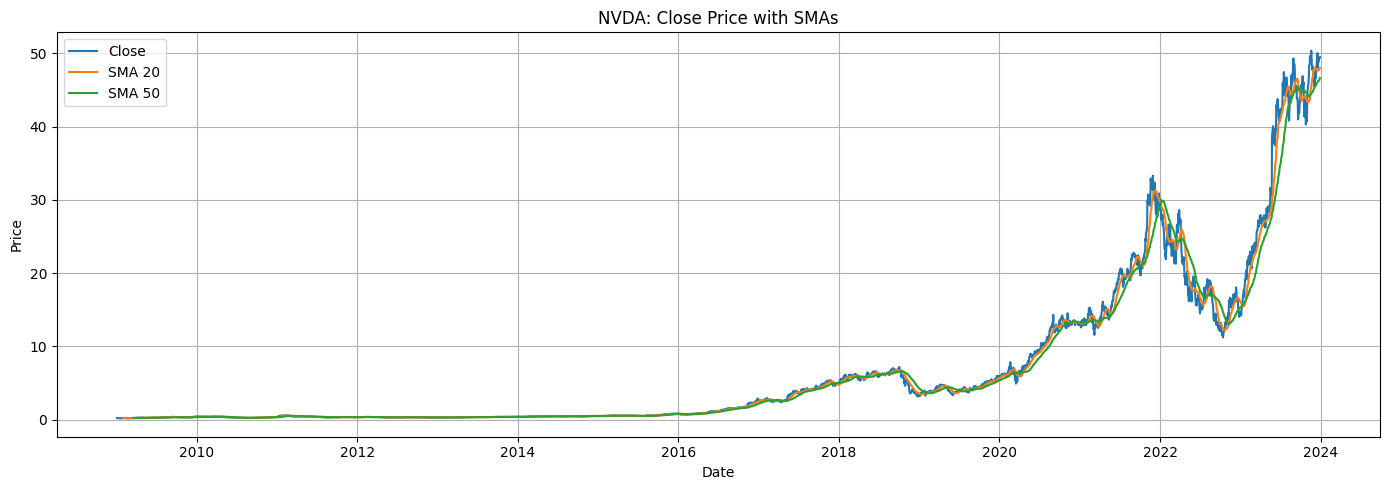

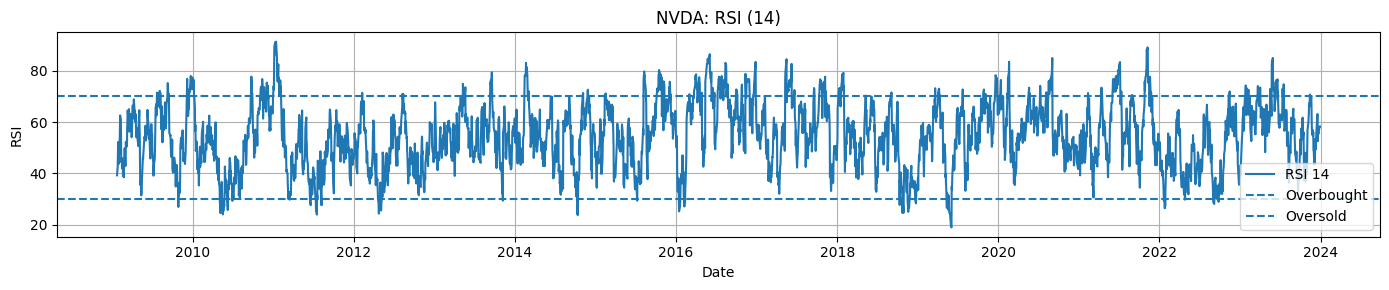

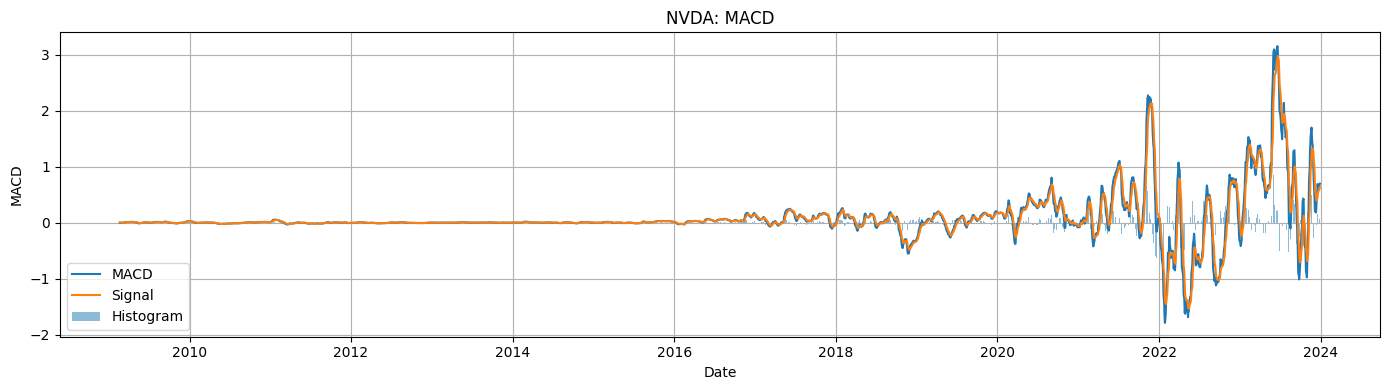

In [17]:
results = {}  # to store DataFrames and metrics per ticker

for ticker in TICKERS:
    print(f"\n=== Processing {ticker} ===")
    
    # Load raw OHLCV data
    df_raw = load_price_data(ticker)

    # Add TA indicators
    df_ind = add_ta_indicators(df_raw)

    # Drop NaN values created by indicators
    df_clean = df_ind.dropna().copy()

    # --- Basic metrics ---
    if "log_return" not in df_clean.columns:
        raise KeyError(f"log_return is missing for {ticker}. Did you re-run add_ta_indicators()?")

    returns = df_clean["log_return"]

    mean_daily = returns.mean()
    std_daily = returns.std()
    annual_return = mean_daily * 252
    annual_vol = std_daily * np.sqrt(252)

    metrics = {
        "mean_daily_return": mean_daily,
        "annual_return": annual_return,
        "annual_volatility": annual_vol,
    }

    print(f"Mean daily return: {mean_daily:.5f}")
    print(f"Annualized return: {annual_return:.2%}")
    print(f"Annualized volatility: {annual_vol:.2%}")

    # Save in dictionary
    results[ticker] = {
        "df": df_ind,
        "metrics": metrics,
    }

    # Plot charts
    plot_ticker_indicators(df_ind, ticker)

    # Save processed CSV
    out_dir = DATA_DIR / "processed"
    out_dir.mkdir(exist_ok=True, parents=True)
    df_ind.to_csv(out_dir / f"{ticker}_with_indicators.csv")
